## 1. Initial Exploration:


In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top = False,input_shape = (150,150,3))
conv_base.summary()

C:\Users\home\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## 2. Extracting features using the Pre-trained Convolutional-base:

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = 'E:\\Anirban_Research\\Experimentation_beg\\cats_n_dogs_small'
train_dir = 'E:\\Anirban_Research\\Experimentation_beg\\cats_n_dogs_small\\train' 
validation_dir = 'E:\\Anirban_Research\\Experimentation_beg\\cats_n_dogs_small\\validation'
test_dir = 'E:\\Anirban_Research\\Experimentation_beg\\cats_n_dogs_small\\test'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,target_size = (150,150),batch_size=batch_size,class_mode = 'binary')
    i = 0
    for input_batch,label_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = label_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features,labels
    
train_features, train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)


train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 3. Defining and Training the densely connected Classifier:

In [3]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation = 'relu',input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_features,train_labels,epochs = 30,batch_size = 20,validation_data = (validation_features,validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.5955 - acc: 0.6750 - val_loss: 0.4532 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4264 - acc: 0.8200 - val_loss: 0.3731 - val_acc: 0.8490
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3710 - acc: 0.8400 - val_loss: 0.3333 - val_acc: 0.8620
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3213 - acc: 0.8710 - val_loss: 0.3025 - val_acc: 0.8930
Epoch 5/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2934 - acc: 0.8775 - val_loss: 0.2870 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2733 - acc: 0.8930 - val_loss: 0.2839 - val_acc: 0.8820
Epoch 7/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.2541 - acc: 0.9015 - val_loss: 0.2648 - val_acc: 0.8980
Epoch 8/30
200

## 4. Plotting the results:

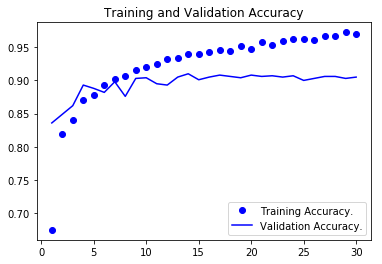

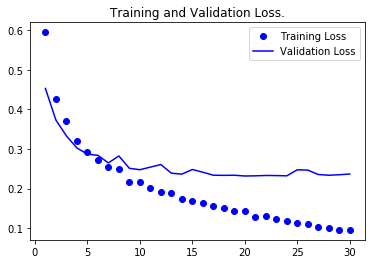

In [4]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy.')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy.')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label = 'Training Loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss.')
plt.legend()

plt.show()

## 5. Test Accuracy:


In [6]:
test_loss,test_acc = model.evaluate(test_features,test_labels)
print('Test Accuracy: ',test_acc)

1000/1000 [==============================] - 0s 406us/step
Test Accuracy:  0.874


## 6. Saving the Model:

In [7]:
model.save('cats_n_dogs_small_2.h5')